<a href="https://colab.research.google.com/github/valsson-group/Information-for-New-Members-in-Valsson-Group/blob/main/Python-JupyterNotebooks/HF_MolecularOrbitals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Orbitals from Hartree-Fock Calculations

Simple Juypter notebook that performs Hartree-Fock calculations using pyscf.

Part of the code take from and inspired by https://www.andersle.no/posts/2022/mo/mo.html

## Setup python environment and imports

In [1]:
%%capture
!pip install numpy
!pip install scipy
!pip install Cython
!pip install pandas
!pip install sklearn
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install rdkit
!pip install py3Dmol
!pip install ipywidgets
!pip install sphinx
!pip install nbsphinx
!pip install pydata-sphinx-theme
!pip install lxml
!pip install fortecubeview
!pip install pythreejs
!pip install scikit-image
!pip install pyscf
!pip install shap
!pip install catboost
!pip install graphviz

In [2]:
import pathlib

# RDKit imports:
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True  # Use higher quality images for molecules

# For visualization of molecules and orbitals:
import py3Dmol
import fortecubeview

# pyscf imports:
import pyscf

# For plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="ticks", context="talk", palette="muted")

# For numerics:
import numpy as np
import pandas as pd

from google.colab import output
output.enable_custom_widget_manager()

pd.options.display.float_format = "{:,.3f}".format


def write_cube_files(
    max_homo_lumo=5, prefix="", dirname=".", margin=5, write_all_orbitals=False
):
    """Write cube files for the given coefficients."""
    path = pathlib.Path(dirname)
    path.mkdir(parents=True, exist_ok=True)

    # find index of HOMO and LUMO
    lumo = float("inf")
    lumo_idx = None
    homo = -float("inf")
    homo_idx = None
    for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
        if occ > 0 and energy > homo:
            homo = energy
            homo_idx = i
        if occ == 0 and energy < lumo:
            lumo = energy
            lumo_idx = i

    if(write_all_orbitals):
      for i in range(mf.mo_coeff.shape[1]):
        outfile = f"{prefix}Orbital-{i:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        pyscf.tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, i], margin=margin)
    else:
      print(f"HOMO (index): {homo_idx}")
      print(f"LUMO (index): {lumo_idx}")
      print("")
      outfile = f"{prefix}HOMO.cube"
      outfile = path / outfile
      print(f"Writing {outfile}")
      pyscf.tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, homo_idx], margin=margin)

      outfile = f"{prefix}LUMO.cube"
      outfile = path / outfile
      print(f"Writing {outfile}")
      pyscf.tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, lumo_idx], margin=margin)

      for i in range(1,max_homo_lumo+1):
        outfile = f"{prefix}HOMO_minus-{i:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        pyscf.tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, homo_idx-i], margin=margin)

        outfile = f"{prefix}LUMO_plus-{i:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        pyscf.tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, lumo_idx+i], margin=margin)

## Definition of Molecule from SMILES String

**Here you should define the smiles string for the molecule you want to consider**




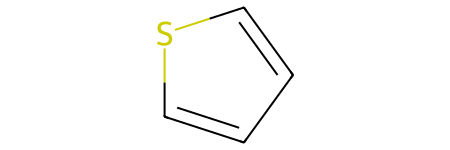

In [4]:
molecule_smiles = "C1=CSC=C1" #@param {type:"string"}

molecule_name = "Mol"
molecule = Chem.MolFromSmiles(molecule_smiles)  # Generate the molecule from smiles
molecule

## Setup of Molecule

In [5]:
def get_xyz(molecule, optimize=False):
    """Get xyz-coordinates for the molecule"""
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    if optimize:  # Optimize the molecules with the MM force field:
        AllChem.MMFFOptimizeMolecule(mol)
    xyz = []
    for lines in Chem.MolToXYZBlock(mol).split("\n")[2:]:
        strip = lines.strip()
        if strip:
            xyz.append(strip)
    xyz = "\n".join(xyz)
    return mol, xyz

In [6]:
molecule3d, xyz = get_xyz(molecule, optimize=True)
print(xyz)

C     -0.710683   -0.711168    0.008070
C     -1.230108    0.563616   -0.049109
S     -0.004188    1.758002   -0.061898
C      1.227404    0.571522    0.009146
C      0.714061   -0.706584    0.041841
H     -1.323897   -1.603776    0.024841
H     -2.270982    0.854511   -0.084122
H      2.266875    0.869110    0.023448
H      1.331519   -1.595234    0.087783


In [7]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule3d),
    style={"stick": {}, "sphere": {"scale": 0.3}},
    width=300,
    height=300,
)
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Hartree-Fock Calculations

Here we perform the HF calculations. You will need to select the basis set to be used from the calculation from the drop down lists.

In [8]:
def run_calculation(xyz, basis="sto-3g"):
    """Calculate the energy (+ additional things like MO coefficients) with pyscf."""
    mol = pyscf.gto.M(
        atom=xyz,
        basis=basis,
        unit="ANG",
        symmetry=False,
    )
    mol.build()
    mf = pyscf.scf.RHF(mol).run()
    return mf, mol


def print_homo_lumo_energies(max_homo_lumo=5):

    # find index of HOMO and LUMO
    lumo = float("inf")
    lumo_idx = None
    homo = -float("inf")
    homo_idx = None
    for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
        if occ > 0 and energy > homo:
            homo = energy
            homo_idx = i
        if occ == 0 and energy < lumo:
            lumo = energy
            lumo_idx = i

    # print(f"HOMO (index): {homo_idx}")
    # print(f"LUMO (index): {lumo_idx}")
    # print("")
    print("Molecular Orbitals Energy")
    for i in reversed(range(1,max_homo_lumo)):
      print("- HOMO-{:1}  (MO #{:2d}):  {:7.4f} Hartree".format(i,homo_idx+1-i,  mf.mo_energy[homo_idx-i]))
    print("- HOMO    (MO #{:2d}):  {:7.4f} Hartree".format(homo_idx+1,  mf.mo_energy[homo_idx]))
    print("--------------------------------------")
    print("- LUMO    (MO #{:2d}):  {:7.4f} Hartree".format(homo_idx+1+1,  mf.mo_energy[homo_idx+1]))
    for i in range(1,max_homo_lumo):
      print("- LUMO+{:1}  (MO #{:2d}):  {:7.4f} Hartree".format(i,homo_idx+2+i,  mf.mo_energy[homo_idx+1+i]))

In [9]:
BasisSet = "cc-pVDZ" #@param {type:"string"} ["sto-3g", "cc-pVDZ","6-31G(d)","def2-SVP"]

print("Running HF calculations")
print("- Basis set: {:s}".format(BasisSet))

mf, mol = run_calculation(xyz, basis=BasisSet)

Running HF calculations
- Basis set: cc-pVDZ
converged SCF energy = -551.319942549595


## Analysis of Results

In [10]:
mf.analyze(verbose=4)

**** SCF Summaries ****
Total Energy =                        -551.319942549594998
Nuclear Repulsion Energy =             202.627882340752592
One-electron Energy =                -1158.657006310633733
Two-electron Energy =                  404.709181420286200
**** MO energy ****
MO #1   energy= -91.9796245214661  occ= 2
MO #2   energy= -11.2645233266986  occ= 2
MO #3   energy= -11.2644941541203  occ= 2
MO #4   energy= -11.243340768567   occ= 2
MO #5   energy= -11.2423569756559  occ= 2
MO #6   energy= -8.98389793058397  occ= 2
MO #7   energy= -6.6654909665316   occ= 2
MO #8   energy= -6.66446125081374  occ= 2
MO #9   energy= -6.66263548018869  occ= 2
MO #10  energy= -1.1706100262791   occ= 2
MO #11  energy= -0.986497031016238 occ= 2
MO #12  energy= -0.979594990776697 occ= 2
MO #13  energy= -0.763251064331062 occ= 2
MO #14  energy= -0.749637484127577 occ= 2
MO #15  energy= -0.693752505926534 occ= 2
MO #16  energy= -0.570166042671188 occ= 2
MO #17  energy= -0.546687297175469 occ= 2
MO #18

((array([1.99998675e+00, 9.76879882e-01, 4.65845375e-03, 1.02736425e+00,
         1.05691569e+00, 1.03148434e+00, 5.87264087e-03, 5.50573869e-03,
         5.08972930e-03, 1.72513602e-03, 1.50221926e-03, 2.24568685e-03,
         1.05835986e-03, 2.69795446e-03, 1.99998725e+00, 1.02697882e+00,
         3.95696268e-03, 1.06652786e+00, 1.01308015e+00, 1.09117059e+00,
         4.49427076e-03, 5.15601647e-03, 8.58195464e-03, 4.51698900e-03,
         1.86115100e-03, 2.95046157e-03, 1.38327264e-03, 1.43451475e-03,
         1.99999949e+00, 1.99997113e+00, 1.63234807e+00, 4.66320809e-03,
         1.99997460e+00, 1.99998808e+00, 1.99999474e+00, 9.36494956e-01,
         1.40532274e+00, 1.69879973e+00, 1.43778345e-02, 3.97688336e-03,
         1.73452397e-03, 1.93157051e-02, 4.17439133e-03, 7.33218652e-03,
         9.15753503e-03, 1.47021760e-03, 1.99998725e+00, 1.02697852e+00,
         3.95697206e-03, 1.06595198e+00, 1.01385807e+00, 1.09096906e+00,
         4.49575077e-03, 5.15404538e-03, 8.58246022

In [11]:
print_homo_lumo_energies()

Molecular Orbitals Energy
- HOMO-4  (MO #18):  -0.5268 Hartree
- HOMO-3  (MO #19):  -0.5203 Hartree
- HOMO-2  (MO #20):  -0.4748 Hartree
- HOMO-1  (MO #21):  -0.3438 Hartree
- HOMO    (MO #22):  -0.3227 Hartree
--------------------------------------
- LUMO    (MO #23):   0.1253 Hartree
- LUMO+1  (MO #24):   0.1929 Hartree
- LUMO+2  (MO #25):   0.1957 Hartree
- LUMO+3  (MO #26):   0.2182 Hartree
- LUMO+4  (MO #27):   0.2324 Hartree


In [12]:
table = pd.DataFrame({"Energy": mf.mo_energy, "Occupancy": mf.mo_occ})
table

,Energy,Occupancy
0,-91.980,2.000
1,-11.265,2.000
2,-11.264,2.000
3,-11.243,2.000
4,-11.242,2.000
...,...,...
89,2.749,0.000
90,2.864,0.000
91,2.945,0.000
92,3.053,0.000


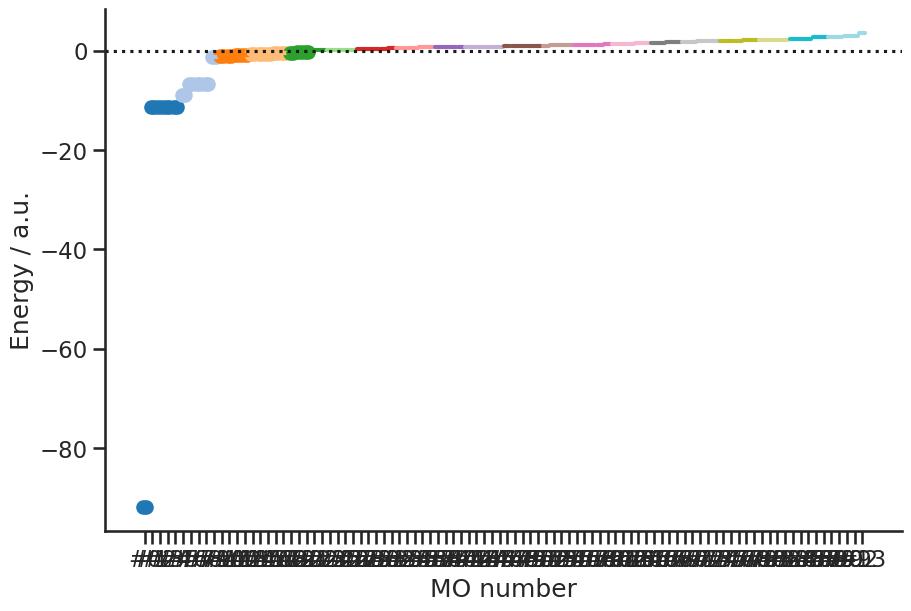

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(9, 6))
colors = matplotlib.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(mf.mo_energy)))

pos = []
for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
    left = 3 * i
    right = 3 * i + 2.5
    length = right - left

    (line,) = ax.plot([left, right], [energy, energy], color=colors[i], lw=3)

    electron_x, electron_y = None, None
    if occ == 2:
        electron_x = [left + 0.25 * length, left + 0.75 * length]
        electron_y = [energy, energy]
    elif occ == 1:
        electron_x, electron_y = [left + 0.5], [energy]
    if electron_x and electron_y:
        ax.scatter(electron_x, electron_y, color=line.get_color())

    pos.append(left + 0.5 * length)

ax.axhline(y=0, ls=":", color="k")
ax.set_xticks(pos)
ax.set_xticklabels([f"#{i}" for i, _ in enumerate(pos)])
ax.set(xlabel="MO number", ylabel="Energy / a.u.")
sns.despine(fig=fig)

## Setup Orbitals

In [14]:
!rm -rf cube_files
write_cube_files(
   dirname="cube_files",
   write_all_orbitals=False
)

HOMO (index): 21
LUMO (index): 22

Writing cube_files/HOMO.cube
Writing cube_files/LUMO.cube
Writing cube_files/HOMO_minus-01.cube
Writing cube_files/LUMO_plus-01.cube
Writing cube_files/HOMO_minus-02.cube
Writing cube_files/LUMO_plus-02.cube
Writing cube_files/HOMO_minus-03.cube
Writing cube_files/LUMO_plus-03.cube
Writing cube_files/HOMO_minus-04.cube
Writing cube_files/LUMO_plus-04.cube
Writing cube_files/HOMO_minus-05.cube
Writing cube_files/LUMO_plus-05.cube


## Visualize Orbitals

In [ ]:
fortecubeview.plot(path="./cube_files/", width=600, height=300, colorscheme='national')